In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install autogluon

In [3]:
!ls drive/MyDrive/pfa-case

'Kopi af Kopi af model.ipynb'   san-francisco-ca_.geojson   sf_districts.gsheet
'Kopi af model.ipynb'	        sf_data.csv		   'Unavngiven præsentation.gslides'
 model.ipynb		        sf_districts.csv	    visualize.ipynb


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

###load data

In [5]:
data_path = 'drive/MyDrive/pfa-case/sf_data.csv'
districts_path = 'drive/MyDrive/pfa-case/sf_districts.csv'

In [6]:
crime_data = pd.read_csv(data_path, sep=";")
crime_data

,id,category,description,weekday,date,time,resolution,longitude,latitude,label
0,5069701104134,assault,battery,wednesday,06/22/2005,12:20,none,-122.428223,37.781896,violent
1,6074729204104,assault,assault,saturday,07/15/2006,00:55,none,-122.410672,37.799789,violent
2,7103536315201,assault,stalking,tuesday,09/25/2007,00:01,none,-122.458226,37.741362,violent
3,11082415274000,missing person,missing adult,saturday,09/24/2011,11:00,located,-122.459173,37.708200,other
4,4037801104134,assault,battery,friday,12/12/2003,12:00,none,-122.386667,37.789882,violent
...,...,...,...,...,...,...,...,...,...,...
2129211,17050730416710,drug/narcotic,possession of narcotics paraphernalia,thursday,06/22/2017,01:42,"arrest, cited",-122.398699,37.798880,intoxication
2129212,17071435504014,assault,aggravated assault with bodily force,friday,09/01/2017,17:00,none,-122.443312,37.770470,violent
2129213,17053348465010,other offenses,traffic violation arrest,friday,06/30/2017,17:50,"arrest, booked",-122.387068,37.755446,other
2129214,17102776330130,other offenses,peddling without a license,wednesday,12/20/2017,15:41,"arrest, booked",-122.412515,37.780478,other


###transform data for model

In [7]:
crime_data['date'] = pd.to_datetime(crime_data['date'])

# Extract the year and create a new column
crime_data['year'] = crime_data['date'].dt.year

crime_data['day'] = (crime_data['date'] - pd.to_datetime(crime_data['date'].dt.year, format='%Y')) / pd.Timedelta(days=1)

crime_data['time'] = pd.to_datetime(crime_data['time'])
# Calculate total minutes elapsed since midnight
crime_data['minute'] = crime_data['time'].dt.hour * 60 + crime_data['time'].dt.minute


<ipython-input-7-d1918996bb17>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data['time'] = pd.to_datetime(crime_data['time'])


In [30]:

# Function to map categories to new categories
def map_new_category(category):
    if category in ['assault', 'kidnapping', 'robbery', 'sex offenses, forcible']:
        return 'Violent Crimes'
    elif category in ['larceny/theft', 'vehicle theft', 'vandalism', 'burglary', 'stolen property', 'arson']:
        return 'Property Crimes'
    # elif category in ['larceny/theft']:
    #     return 'larceny/theft'
    elif category in ['drug/narcotic', 'driving under the influence', 'liquor laws']:
        return 'Drug and Substance Related Crimes'
    # elif category in ['missing person', 'suspicious occ', 'non-criminal', 'other offenses', 'trespass', 'disorderly conduct', 'loitering', 'forgery/counterfeiting', 'embezzlement', 'fraud', 'extortion', 'bad checks', 'bribery', 'pornography/obscene mat']:
    #     return 'Miscellaneous Crimes'
    # elif category in ['prostitution', 'gambling']:
    #     return 'Vice and Morality Related Crimes'
    elif category in ['weapon laws', 'warrants', 'secondary codes']:
        return 'Legal Violations'
    # elif category == 'sex offenses, non forcible':
    #     return 'Sexual Offenses'
    else:
        return 'Other'

# Apply the function to create the new_category column
crime_data['new_category'] = crime_data['category'].apply(map_new_category)

# Display the updated dataframe
crime_data

,id,category,description,weekday,date,time,resolution,longitude,latitude,label,year,day,minute,new_category,weights,input_category,new_input_category,input_weekday
0,5069701104134,assault,battery,wednesday,2005-06-22,2024-02-08 12:20:00,none,-122.428223,37.781896,violent,2005,172.0,740,Violent Crimes,1.416970,1,0,6
1,6074729204104,assault,assault,saturday,2006-07-15,2024-02-08 00:55:00,none,-122.410672,37.799789,violent,2006,195.0,55,Violent Crimes,1.416970,1,0,2
2,7103536315201,assault,stalking,tuesday,2007-09-25,2024-02-08 00:01:00,none,-122.458226,37.741362,violent,2007,267.0,1,Violent Crimes,1.416970,1,0,5
4,4037801104134,assault,battery,friday,2003-12-12,2024-02-08 12:00:00,none,-122.386667,37.789882,violent,2003,345.0,720,Violent Crimes,1.416970,1,0,0
5,4147669007025,vehicle theft,stolen truck,thursday,2004-12-30,2024-02-08 19:00:00,none,-122.407531,37.723291,other,2004,364.0,1140,Property Crimes,0.402690,13,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129206,17080890805011,burglary,"burglary of apartment house, forcible entry",monday,2017-10-02,2024-02-08 21:00:00,none,-122.412933,37.773927,other,2017,274.0,1260,Property Crimes,0.402690,2,1,1
2129208,16026805516710,drug/narcotic,possession of narcotics paraphernalia,friday,2016-04-01,2024-02-08 10:36:00,"arrest, booked",-122.420212,37.788223,intoxication,2016,91.0,636,Drug and Substance Related Crimes,2.630968,4,3,0
2129211,17050730416710,drug/narcotic,possession of narcotics paraphernalia,thursday,2017-06-22,2024-02-08 01:42:00,"arrest, cited",-122.398699,37.798880,intoxication,2017,172.0,102,Drug and Substance Related Crimes,2.630968,4,3,4
2129212,17071435504014,assault,aggravated assault with bodily force,friday,2017-09-01,2024-02-08 17:00:00,none,-122.443312,37.770470,violent,2017,243.0,1020,Violent Crimes,1.416970,1,0,0


In [31]:
# Removing rows with category 'Other'
crime_data = crime_data[crime_data['new_category'] != 'Other']


In [35]:
#transform labels
# Initialize LabelEncoder
category_encoder = LabelEncoder()
weekday_encoder = LabelEncoder()
new_category_encoder = LabelEncoder()

# Fit and transform the category column
crime_data['input_category'] = category_encoder.fit_transform(crime_data['category'])
crime_data['new_input_category'] = new_category_encoder.fit_transform(crime_data['new_category'])
crime_data['input_weekday'] = weekday_encoder.fit_transform(crime_data['weekday'])

In [36]:
crime_data

,id,category,description,weekday,date,time,resolution,longitude,latitude,label,year,day,minute,new_category,weights,input_category,new_input_category,input_weekday
0,5069701104134,assault,battery,wednesday,2005-06-22,2024-02-08 12:20:00,none,-122.428223,37.781896,violent,2005,172.0,740,Violent Crimes,1.416970,1,3,6
1,6074729204104,assault,assault,saturday,2006-07-15,2024-02-08 00:55:00,none,-122.410672,37.799789,violent,2006,195.0,55,Violent Crimes,1.416970,1,3,2
2,7103536315201,assault,stalking,tuesday,2007-09-25,2024-02-08 00:01:00,none,-122.458226,37.741362,violent,2007,267.0,1,Violent Crimes,1.416970,1,3,5
4,4037801104134,assault,battery,friday,2003-12-12,2024-02-08 12:00:00,none,-122.386667,37.789882,violent,2003,345.0,720,Violent Crimes,1.416970,1,3,0
5,4147669007025,vehicle theft,stolen truck,thursday,2004-12-30,2024-02-08 19:00:00,none,-122.407531,37.723291,other,2004,364.0,1140,Property Crimes,0.402690,13,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129206,17080890805011,burglary,"burglary of apartment house, forcible entry",monday,2017-10-02,2024-02-08 21:00:00,none,-122.412933,37.773927,other,2017,274.0,1260,Property Crimes,0.402690,2,2,1
2129208,16026805516710,drug/narcotic,possession of narcotics paraphernalia,friday,2016-04-01,2024-02-08 10:36:00,"arrest, booked",-122.420212,37.788223,intoxication,2016,91.0,636,Drug and Substance Related Crimes,2.630968,4,0,0
2129211,17050730416710,drug/narcotic,possession of narcotics paraphernalia,thursday,2017-06-22,2024-02-08 01:42:00,"arrest, cited",-122.398699,37.798880,intoxication,2017,172.0,102,Drug and Substance Related Crimes,2.630968,4,0,4
2129212,17071435504014,assault,aggravated assault with bodily force,friday,2017-09-01,2024-02-08 17:00:00,none,-122.443312,37.770470,violent,2017,243.0,1020,Violent Crimes,1.416970,1,3,0


###split data

In [38]:
from sklearn.model_selection import train_test_split

# 1. Prepare Data
features =  ['id', 'year', 'day', 'minute', 'input_weekday', 'longitude', 'latitude', 'new_category']
X = crime_data[features]
y = crime_data['input_category']  # Target variable

Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
X_train

,id,year,day,minute,input_weekday,longitude,latitude,new_category
306923,14070179606244,2014,232.0,770,4,-122.403405,37.775421,Property Crimes
1503680,11030144516625,2011,102.0,1020,6,-122.408913,37.781212,Drug and Substance Related Crimes
566619,4004456307021,2004,6.0,600,6,-122.414879,37.803541,Property Crimes
785157,5065227504134,2005,161.0,190,2,-122.410135,37.784189,Violent Crimes
422094,9016517563010,2009,44.0,1020,2,-122.406691,37.785207,Legal Violations
...,...,...,...,...,...,...,...,...
171525,16022789104014,2016,77.0,963,0,-122.411071,37.781751,Violent Crimes
416771,15077455112164,2015,245.0,1170,4,-122.403405,37.775421,Legal Violations
206996,14015592716220,2014,51.0,1439,0,-122.409313,37.784348,Drug and Substance Related Crimes
1076336,6034374306243,2006,88.0,1260,4,-122.387333,37.730129,Property Crimes


###train model


In [42]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(X_train)
train_data.head()
#  sample_weight='balance_weight'
#  sample_weight='weights'
predictor = TabularPredictor(label='new_category',sample_weight='balance_weight', eval_metric='balanced_accuracy').fit(
# predictor = TabularPredictor(label='new_category',sample_weight='balance_weight', weight_evaluation=True).fit(
    train_data,
    num_gpus=1,
    presets='medium_quality',

    time_limit = 1000,
    # hyperparameters = 'light'
    # {
    # 	# 'NN_TORCH': {},
    # 	# 'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
    # 	'CAT': {},
    # 	'XGB': {},
    # 	# 'FASTAI': {},
    # 	# 'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
    # 	# 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
    # 	'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}, {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
    # }
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240208_210842"
Presets specified: ['medium_quality']
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "AutogluonModels/ag-20240208_210842"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
Memory Avail:       8.04 GB / 12.67 GB (63.4%)
Disk Space Avail:   44.09 GB / 78.19 GB (56.4%)
Train Data Rows:    1063348
Train Data Columns: 7
Label Column:       new_category
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	4 unique label values:  ['Property Crimes', 'Drug and S

###evaluate model


In [43]:
#predictions
test_data = TabularDataset(X_test)

metrics = predictor.evaluate(test_data,  detailed_report=True)


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


In [47]:
predictor.evaluate(test_data)

{'balanced_accuracy': 0.5160317373612561,
 'accuracy': 0.6391712245803836,
 'mcc': 0.38322531330019644}

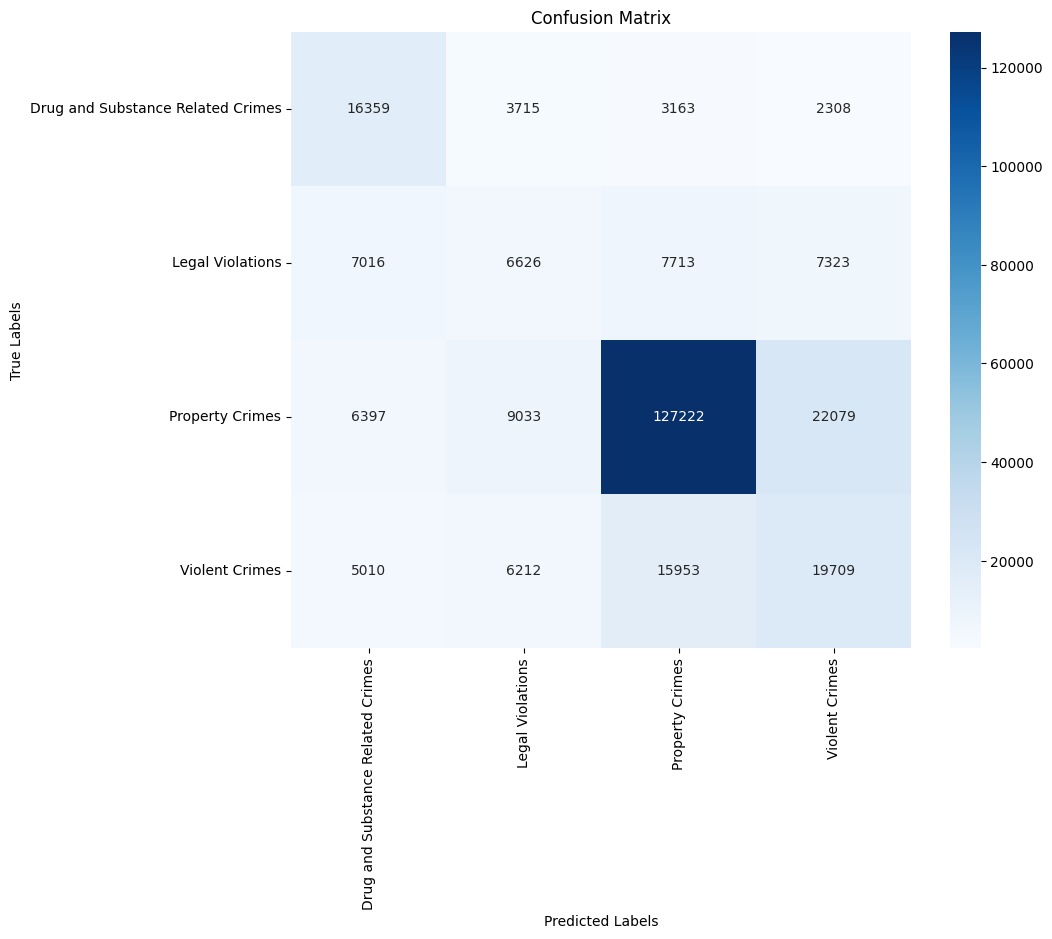

In [46]:
plot_confusion_matrix(metrics['confusion_matrix'])

In [49]:
metrics

{'balanced_accuracy': 0.5160317373612561,
 'accuracy': 0.6391712245803836,
 'mcc': 0.38322531330019644,
 'confusion_matrix':                                    Drug and Substance Related Crimes  \
 Drug and Substance Related Crimes                              16359   
 Legal Violations                                                7016   
 Property Crimes                                                 6397   
 Violent Crimes                                                  5010   
 
                                    Legal Violations  Property Crimes  \
 Drug and Substance Related Crimes              3715             3163   
 Legal Violations                               6626             7713   
 Property Crimes                                9033           127222   
 Violent Crimes                                 6212            15953   
 
                                    Violent Crimes  
 Drug and Substance Related Crimes            2308  
 Legal Violations                   

In [48]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.516032,0.512427,balanced_accuracy,8.071860,0.337067,292.880211,0.015679,0.003258,2.161567,2,True,7
1,RandomForestGini,0.504331,0.501196,balanced_accuracy,6.331113,0.251109,284.605374,6.331113,0.251109,284.605374,1,True,6
2,LightGBMXT,0.436048,0.434600,balanced_accuracy,22.211043,0.868865,107.770108,22.211043,0.868865,107.770108,1,True,4
3,LightGBM,0.428865,0.431180,balanced_accuracy,1.176720,0.049456,18.959907,1.176720,0.049456,18.959907,1,True,5
4,KNeighborsDist,0.424686,0.422879,balanced_accuracy,1.725068,0.082700,6.113270,1.725068,0.082700,6.113270,1,True,2
5,NeuralNetFastAI,0.360282,0.366239,balanced_accuracy,2.867730,0.122603,563.133107,2.867730,0.122603,563.133107,1,True,3
6,KNeighborsUnif,0.338167,0.341253,balanced_accuracy,1.506793,0.126080,9.698736,1.506793,0.126080,9.698736,1,True,1


##The remaining code is building a neural network from scratch, and was not used in the end


In [ ]:
# import numpy as np
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Convert pandas DataFrames to numpy arrays
# X_train_numpy = X_train.to_numpy()
# y_train_numpy = y_train.to_numpy()
# #test dataset
# X_test_numpy = X_test.to_numpy()
# y_test_numpy = y_test.to_numpy()

# X_train_numpy = X_train_numpy[:100]
# y_train_numpy = y_train_numpy[:100]
# X_test_numpy = X_test_numpy[:100]
# y_test_numpy = y_test_numpy[:100]

# # Convert numpy arrays to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_numpy)
# y_train_tensor = torch.tensor(y_train_numpy)

# # 3. Prepare Data
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# batch_size = 1
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



# # Convert numpy arrays to PyTorch tensors
# X_test_tensor = torch.tensor(X_test_numpy)
# y_test_tensor = torch.tensor(y_test_numpy)

# # Prepare Test Data
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# class Classifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(Classifier, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x


# input_dim = X_train.shape[1]  # Number of features
# print(f"{input_dim=}")
# output_dim = len(np.unique(crime_data['input_category']))  # Number of classes
# hidden_dim = 100  # Example hidden layer size
# model = Classifier(input_dim, hidden_dim, output_dim).to(device)



In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Initialize variables to keep track of the best accuracy and the best model
# best_accuracy = 0.0
# best_model_state = None

# # Train the Model
# num_epochs = 1000
# for epoch in range(num_epochs):
#     # Train the model
#     model.train()  # Set the model to train mode
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.float().to(device), labels.to(device)
#         # print(f"{inputs=}")
#         # print(f"{labels=}")
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         probabilities = torch.nn.functional.softmax(outputs, dim=1)
#         _, predicted = torch.max(probabilities, 1)
#         # print(f"{predicted=}")
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Evaluate the model on the test set
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.float().to(device), labels.to(device)
#             outputs = model(inputs)
#             probabilities = torch.nn.functional.softmax(outputs, dim=1)
#             _, predicted = torch.max(probabilities, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     # Calculate test set accuracy
#     accuracy = correct / total
#     print('Epoch [{}/{}], Test Accuracy: {:.2%}'.format(epoch + 1, num_epochs, accuracy))

#     # Save the best model based on test set accuracy
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_model_state = model.state_dict()

# # Load the best model state
# model.load_state_dict(best_model_state)

# # Save the best model
# torch.save(model.state_dict(), 'best_model.pt')
